# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. 

Для решения проблемы:
- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

Данные:
- market_file - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- market_money - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- market_time - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- money - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [1]:
!pip install phik
!pip install shap
!pip install scikit-learn --upgrade

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import phik
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import shap

sns.set(rc={'figure.figsize':(10,7)})

### Загрузка данных

In [3]:
# для начала выгрузим все данные и посмотрим на информацию о них
market_file = pd.read_csv('/datasets/market_file.csv')
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [5]:
market_money = pd.read_csv('/datasets/market_money.csv')
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [6]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [7]:
market_time = pd.read_csv('/datasets/market_time.csv')
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [9]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [10]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


#### Вывод 
- Произвелась выгрузка данных
- Данные в таблицах соответствуют описанию
- Все данные представлены необходимым типом

### Предобработка данных

In [11]:
# проверим данные на наличие пропусков
market_file.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [12]:
market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [13]:
market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [14]:
money.isna().sum()

id         0
Прибыль    0
dtype: int64

Пропуски в данных отсутствуют. Проверим на наличие дубликатов.

In [15]:
# проверям на дубликаты
market_file.duplicated().sum()

0

In [16]:
market_money.duplicated().sum()

0

In [17]:
market_time.duplicated().sum()

0

In [18]:
money.duplicated().sum()

0

Дубликатов также не обнаружно. 

In [19]:
# создадим функцию для вывода уникальных значений 
# она нам нужна для проверки категориальные данных
def uniq(data, column):
    for i in column:
        print(f'Уникальные значение в столбце "{i}": {data[i].unique()}')
        print(' ')

In [20]:
# применим функцию к каждой таблице
uniq(market_file, ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория'])

Уникальные значение в столбце "Покупательская активность": ['Снизилась' 'Прежний уровень']
 
Уникальные значение в столбце "Тип сервиса": ['премиум' 'стандартт' 'стандарт']
 
Уникальные значение в столбце "Разрешить сообщать": ['да' 'нет']
 
Уникальные значение в столбце "Популярная_категория": ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
 


In [21]:
uniq(market_money, ['Период'])

Уникальные значение в столбце "Период": ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
 


In [22]:
uniq(market_time, ['Период'])

Уникальные значение в столбце "Период": ['текущий_месяц' 'предыдцщий_месяц']
 


In [23]:
# следует избавиться от ошибок в данных

# заменим "стандартт" на "стандарт" в столбце "Тип сервиса"
market_file['Тип сервиса'] = market_file['Тип сервиса'].str.replace('стандартт', 'стандарт')

# проверим
market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [24]:
# заменим "предыдцщий" на "предыдущий" в столбце "Период"
market_time['Период'] = market_time['Период'].str.replace('предыдцщий', 'предыдущий')

# проверим
market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

#### Вывод 
- Была проведена предобработка данных
- Ошибки в данных были исправлены
- Пропуски и дубликаты обнаружены не были

### Исследовательский анализ данных

In [25]:
# для начала выведем матрицу с описанием данных для каждой таблице
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [26]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


In [27]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


In [28]:
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


In [29]:
# для более глубокого изучения построим графики для категориальных и количественных данных
# создадим функцию для построение boxplot
def graph_box(data):
    for i in data.columns:
        data.boxplot(column=i, figsize=(8,8))
        plt.title(f'График распределения значение столбца {i}')
        plt.show()

In [30]:
# создадим функцию для построения гистограмм
def graph_hist(data):
    for i in data.columns.unique():
        fig, ax = plt.subplots(figsize=(12, 12))
        plt.hist(data[i])
        plt.title(f'Гистограмма распределений для столбца {i}')
        plt.show()

In [31]:
# создадим функцию для построения pieplot
def graph_pie(data):
    for i in data.columns.unique():
        data[i].value_counts().plot(
            kind='pie', 
            figsize=(8, 8),
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'}, 
            legend=False,
            subplots=False)
        plt.title(f'Соотношение значений в столбце {i}')
        plt.show()

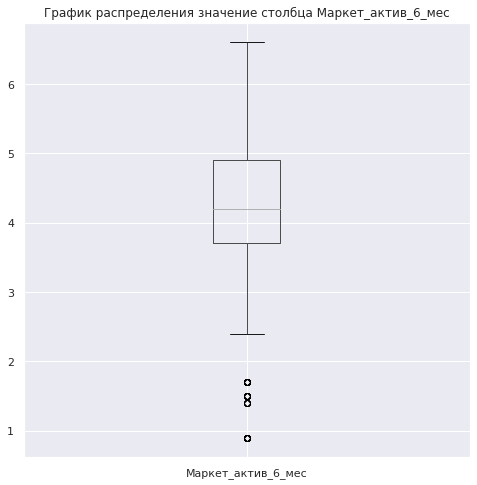

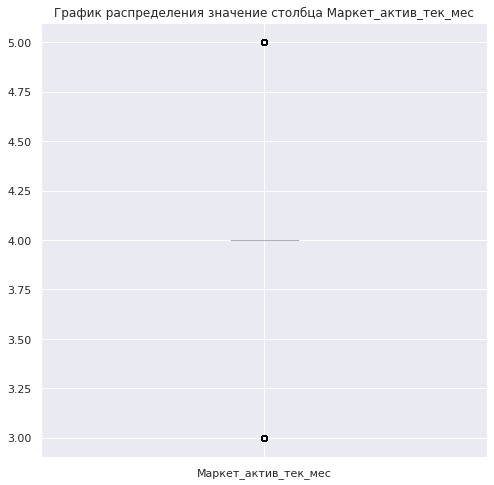

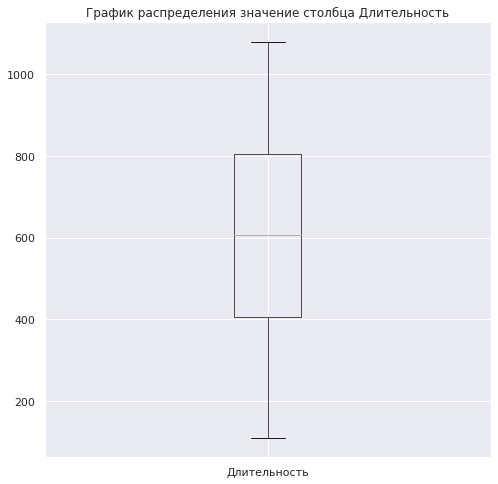

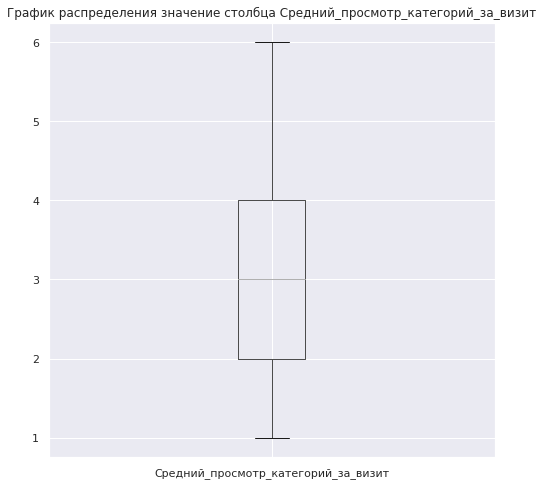

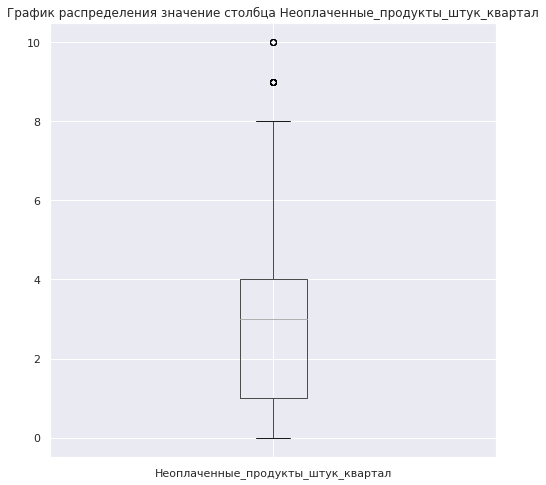

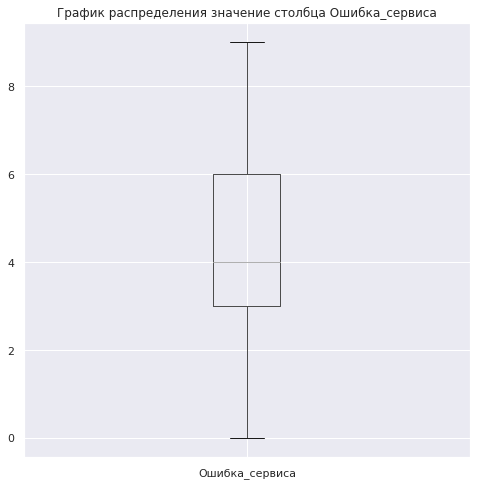

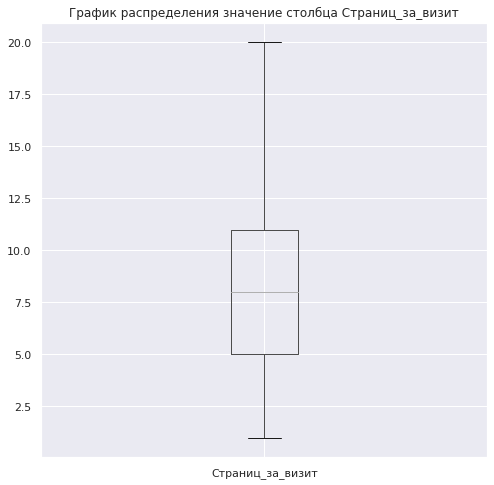

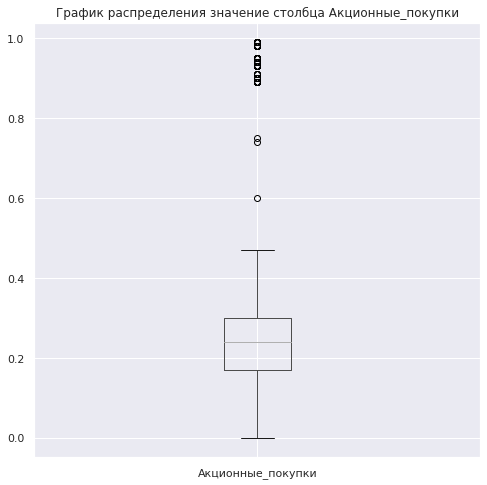

In [32]:
# построим boxplot для количественных переменных таблицы market_file
graph_box(market_file[['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Акционные_покупки']])

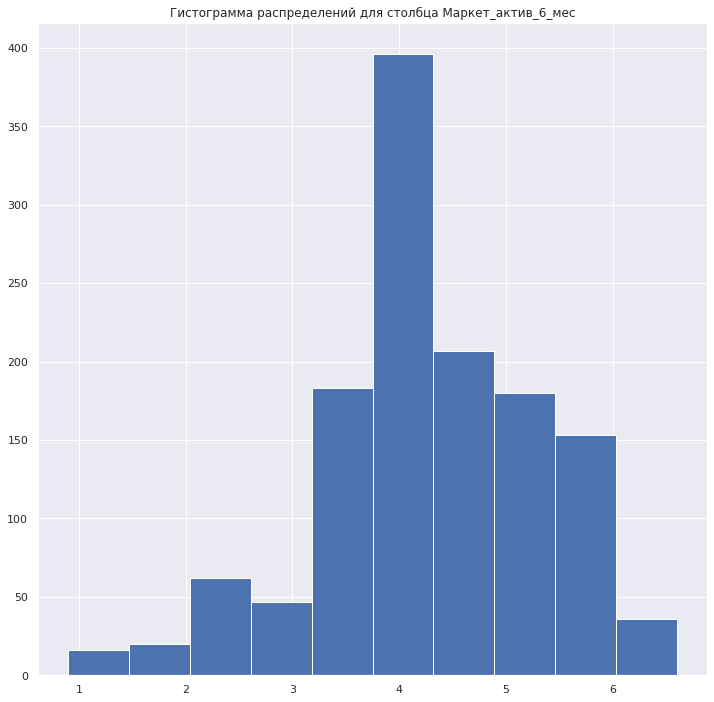

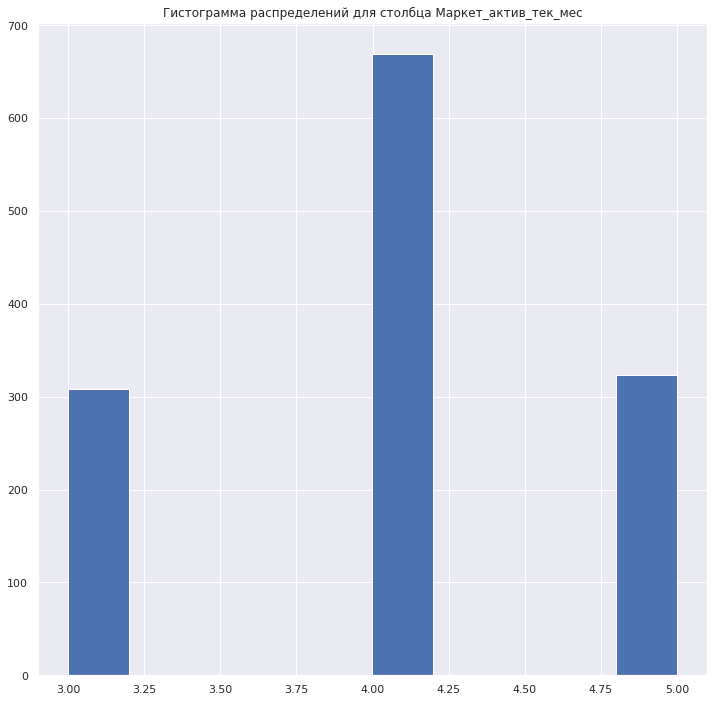

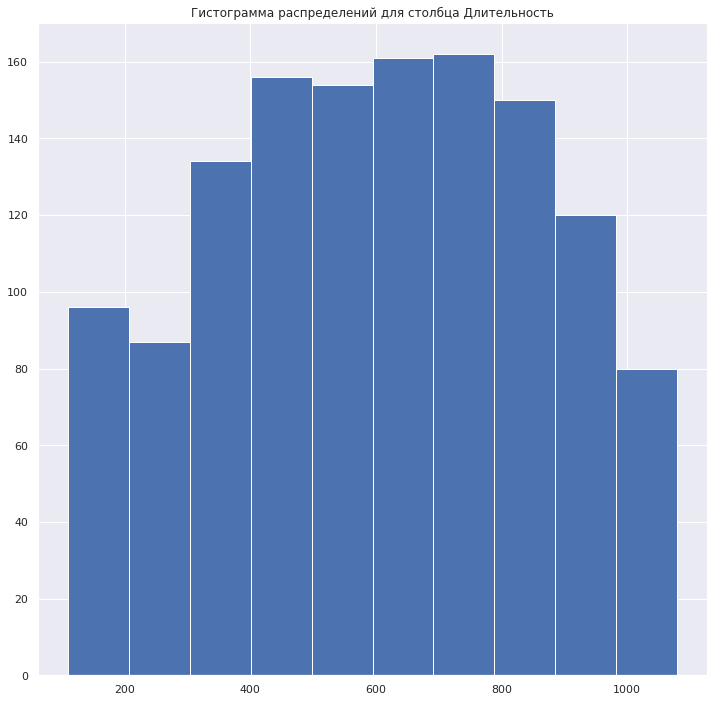

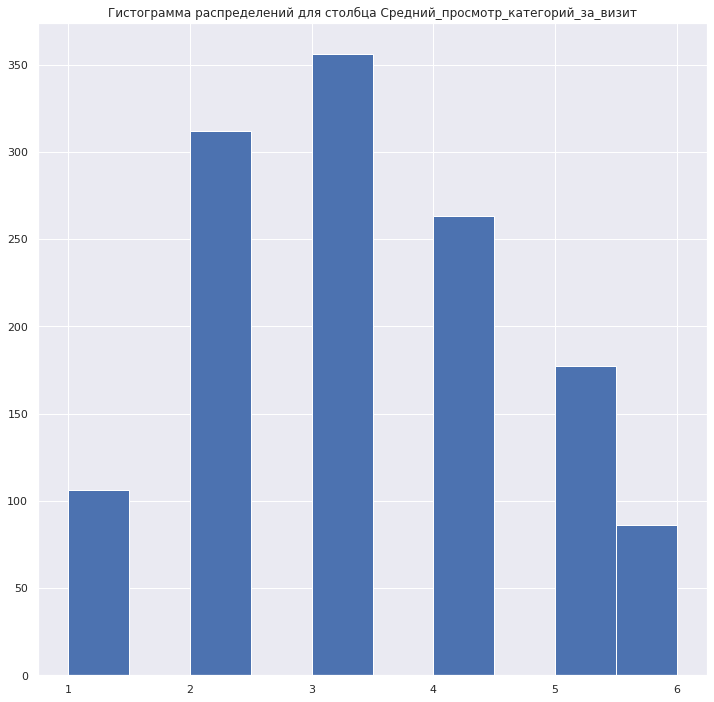

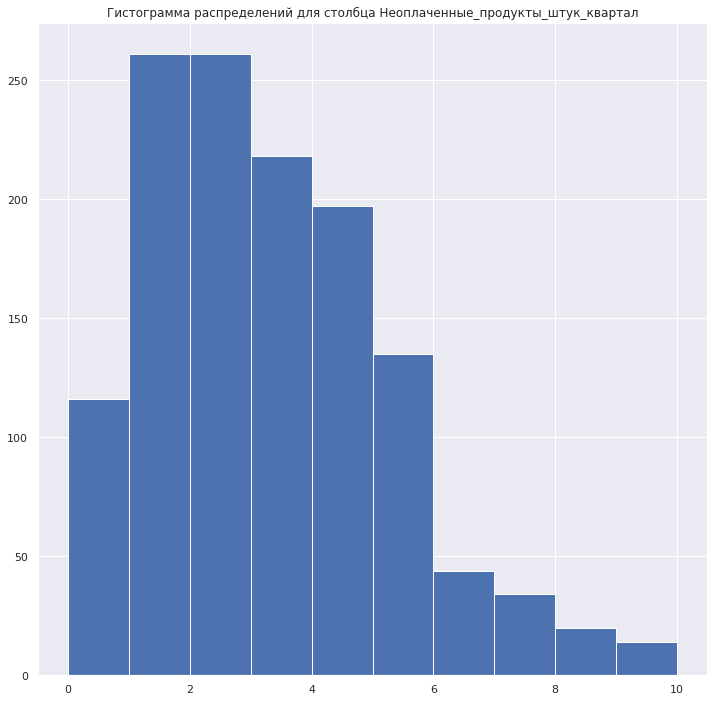

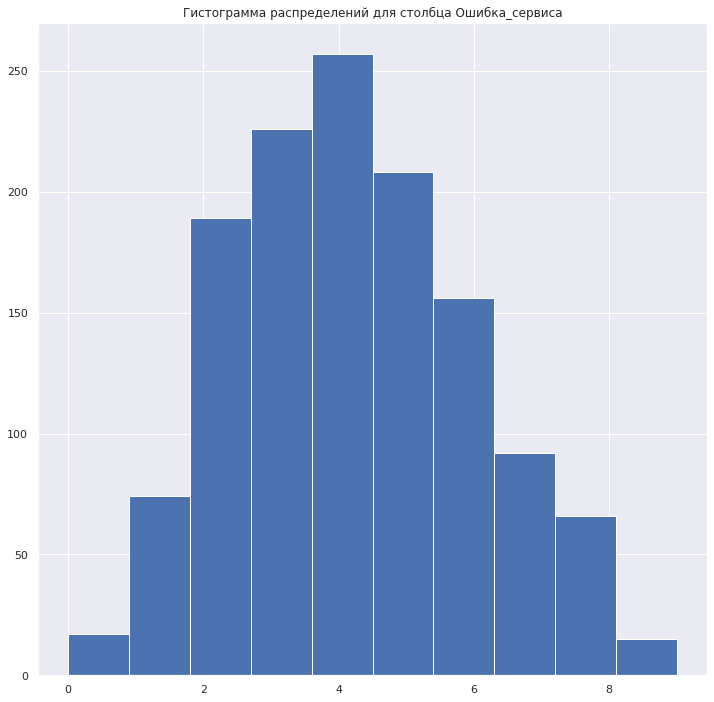

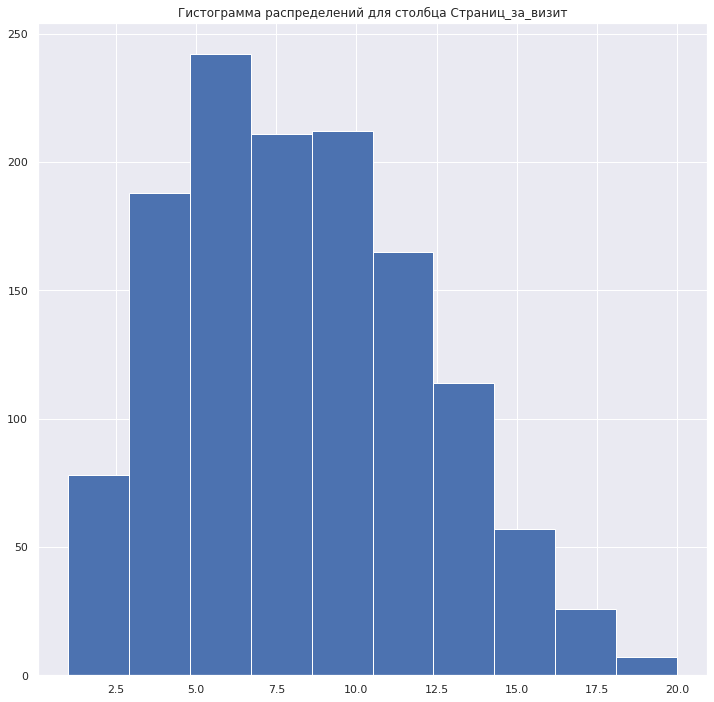

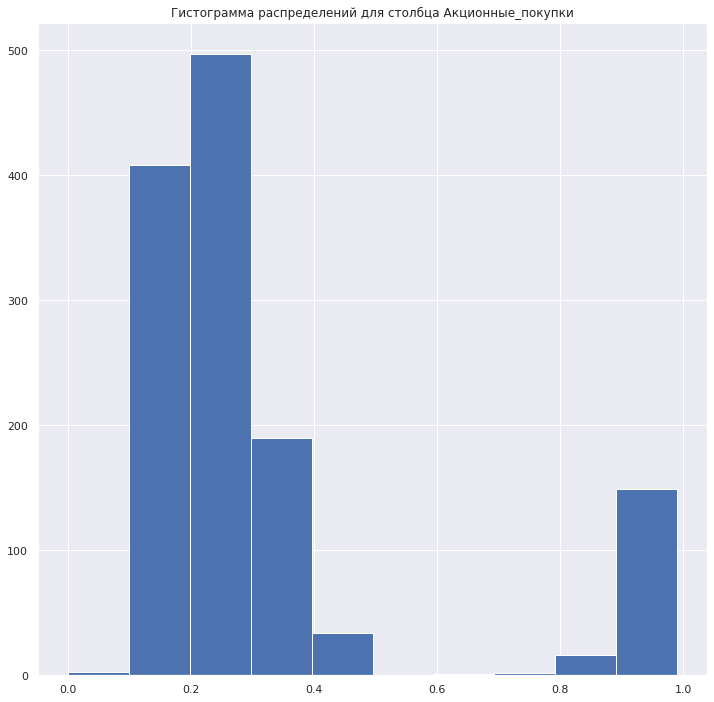

In [33]:
# посмотрим на распределение количественных признаков, построим гистограммы
graph_hist(market_file[['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Акционные_покупки']])

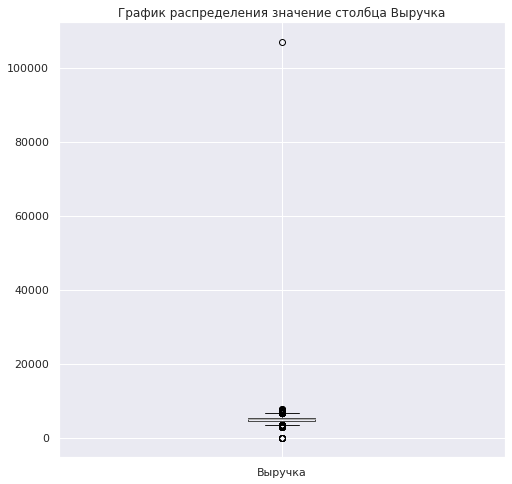

In [34]:
# построим boxplot для количественных переменных таблицы market_money
graph_box(market_money[['Выручка']])

In [35]:
# в данных явно аномальное значение, удалим его
market_money = market_money.query('Выручка < 20000')

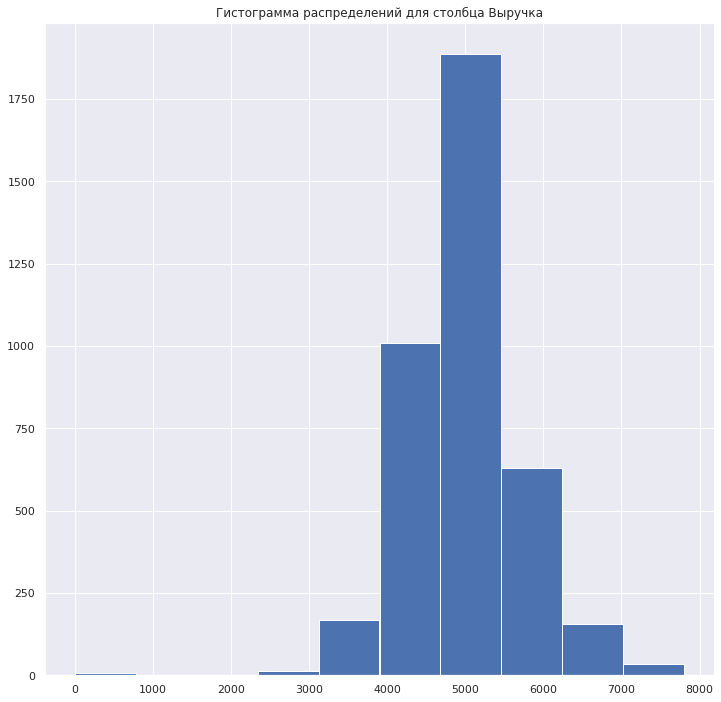

In [36]:
# посмотрим на распределение количественных признаков, построим гистограммы
graph_hist(market_money[['Выручка']])

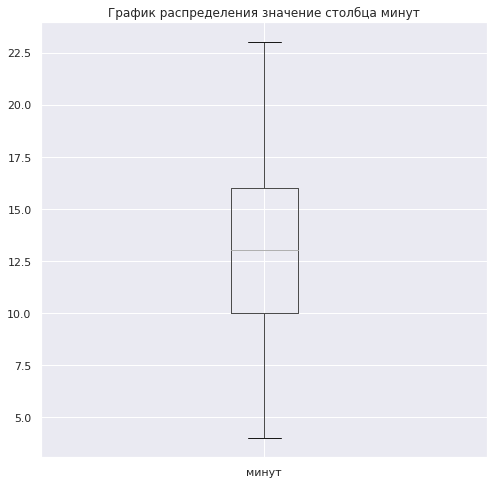

In [37]:
# построим boxplot для количественных переменных таблицы market_time
graph_box(market_time[['минут']])

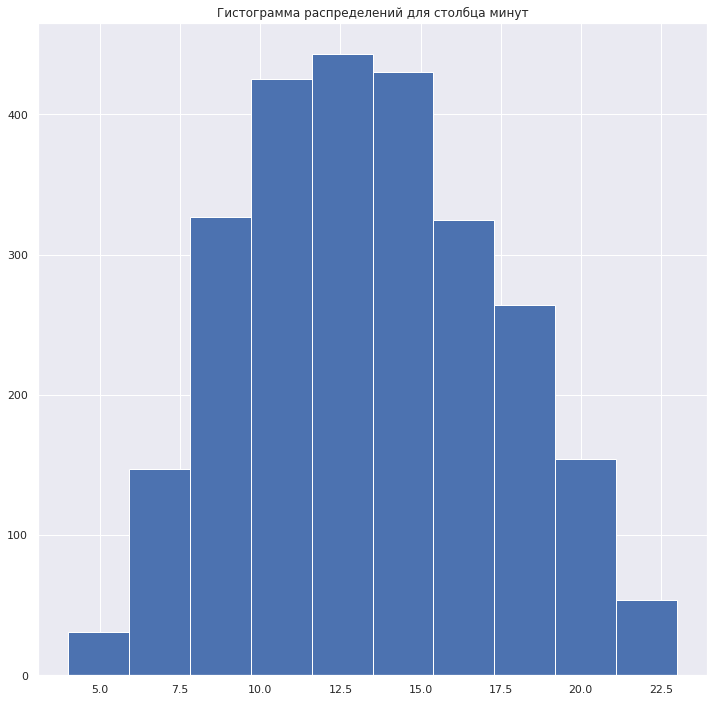

In [38]:
# посмотрим на распределение количественных признаков, построим гистограммы
graph_hist(market_time[['минут']])

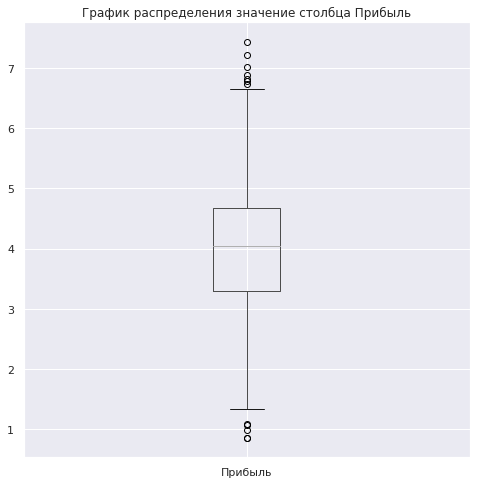

In [39]:
# построим boxplot для количественных переменных таблицы money
graph_box(money[['Прибыль']])

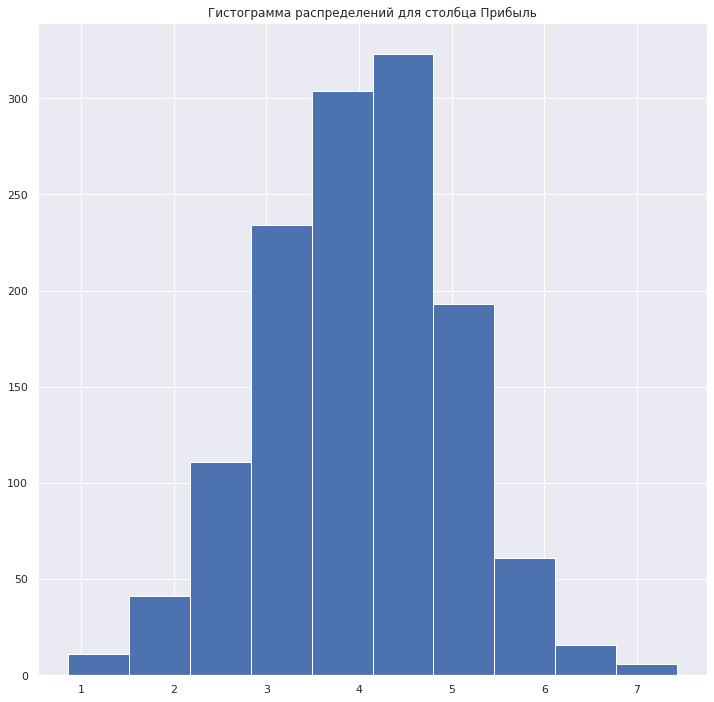

In [40]:
# посмотрим на распределение количественных признаков, построим гистограммы
graph_hist(money[['Прибыль']])

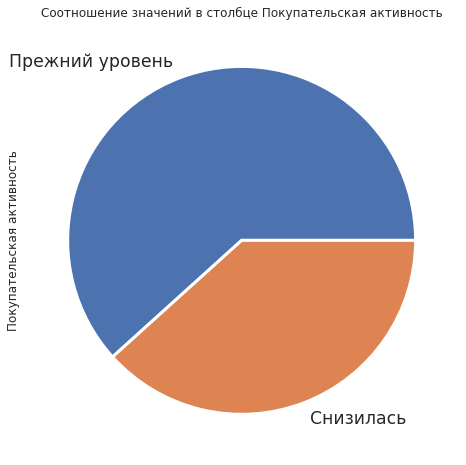

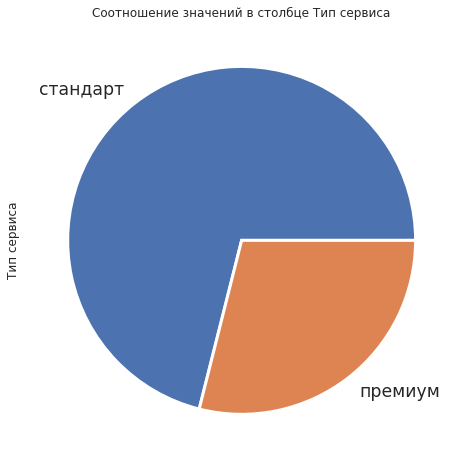

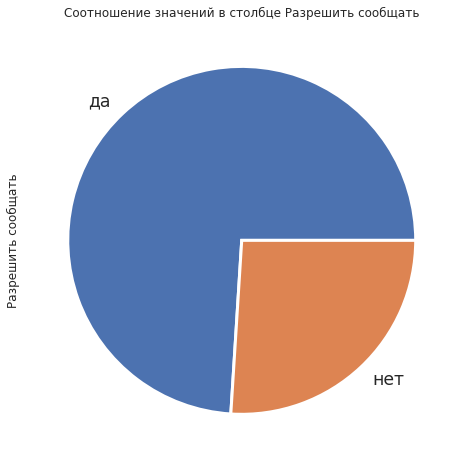

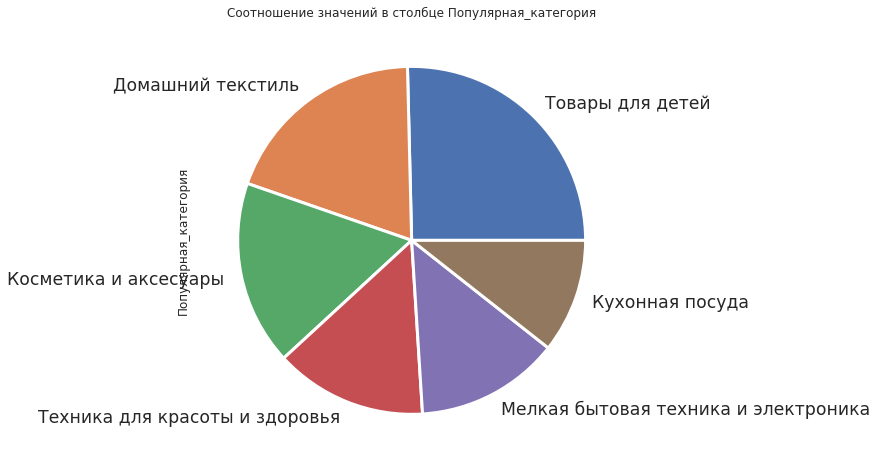

In [41]:
# построим графики для категориальных переменных
graph_pie(market_file[['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']])

In [42]:
# посмотрим на распределение классов целевого признака
market_file['Покупательская активность'].value_counts()

Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64

#### Вывод 
- Был проведен исследовательский анализ данных
- Была изучена матрица описания данных, а также построены графики для различных типов данных
- Некоторые количественные признаки распределены ненормально (соответственно, при корреляционном анализе корреляция Пирсона не подходит)
- Было аномальное значение, которое было удалено
- У целевого признака наблюдается небольшой дисбаланс (примерно 40 к 60), но это не критично, используем стратификацию при разделении на выборки

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Графический анализ вполне приемлемый

### Объединение таблиц

In [43]:
# разделим дф market_money по периодам и объеденим с market_file
df1 = market_money[market_money['Период']== 'препредыдущий_месяц'] 
df1.columns = ['id', 'период1', 'выручка1'] 
market = market_file.merge(df1) 
df2 = market_money[market_money['Период']== 'предыдущий_месяц'] 
df2.columns = ['id', 'период2', 'выручка2'] 
market = market.merge(df2) 
df3 = market_money[market_money['Период']== 'текущий_месяц'] 
df3.columns = ['id', 'период3', 'выручка3'] 
market = market.merge(df3) 

market.head() # проверим

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,период1,выручка1,период2,выручка2,период3,выручка3
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,препредыдущий_месяц,0.0,предыдущий_месяц,0.0,текущий_месяц,3293.1
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,препредыдущий_месяц,4472.0,предыдущий_месяц,5216.0,текущий_месяц,4971.6
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,препредыдущий_месяц,4826.0,предыдущий_месяц,5457.5,текущий_месяц,5058.4
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,препредыдущий_месяц,4793.0,предыдущий_месяц,6158.0,текущий_месяц,6610.4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,препредыдущий_месяц,4594.0,предыдущий_месяц,5807.5,текущий_месяц,5872.5


In [44]:
# то же самое сделаем и с market_time
t2 = market_time[market_time['Период']== 'предыдущий_месяц'] 
t2.columns = ['id', 'период2', 'время2'] 
market = market.merge(t2, on=['id', 'период2']) 
t3 = market_time[market_time['Период']== 'текущий_месяц'] 
t3.columns = ['id', 'период3', 'время3'] 
market = market.merge(t3, on=['id', 'период3'])

market.head(10) # проверим

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,...,Ошибка_сервиса,Страниц_за_визит,период1,выручка1,период2,выручка2,период3,выручка3,время2,время3
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,...,1,5,препредыдущий_месяц,0.0,предыдущий_месяц,0.0,текущий_месяц,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,2,5,препредыдущий_месяц,4472.0,предыдущий_месяц,5216.0,текущий_месяц,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,1,5,препредыдущий_месяц,4826.0,предыдущий_месяц,5457.5,текущий_месяц,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,6,4,препредыдущий_месяц,4793.0,предыдущий_месяц,6158.0,текущий_месяц,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,3,2,препредыдущий_месяц,4594.0,предыдущий_месяц,5807.5,текущий_месяц,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,1,4,препредыдущий_месяц,5124.0,предыдущий_месяц,4738.5,текущий_месяц,5388.5,10,10
6,215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,...,7,2,препредыдущий_месяц,4503.0,предыдущий_месяц,5685.0,текущий_месяц,5869.6,11,12
7,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,...,6,4,препредыдущий_месяц,4749.0,предыдущий_месяц,3263.0,текущий_месяц,3772.6,12,10
8,215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,...,1,3,препредыдущий_месяц,4433.0,предыдущий_месяц,4146.5,текущий_месяц,4566.4,6,7
9,215357,Снизилась,стандарт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,...,9,5,препредыдущий_месяц,0.0,предыдущий_месяц,0.0,текущий_месяц,5986.3,12,6


In [45]:
# выделим покупателей, которые были активны в последние 3 месяца (выручка в эти месяцы не равна 0)
market = market.query('выручка1 > 0 and выручка2 > 0 and выручка3 > 0')

In [46]:
# проверим 
market.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка1,выручка2,выручка3,время2,время3
count,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000
mean,215999.464506,4.256404,4.009259,602.967593,0.320069,3.267747,2.841821,4.184414,8.187500,4836.202160,4947.468750,5238.096065,13.470679,13.210648
std,374.327860,1.013525,0.696316,249.195823,0.249159,1.355125,1.974074,1.951719,3.978459,333.514091,700.797239,834.318717,3.937630,4.221794
min,215349.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,4098.000000,2890.000000,2758.700000,5.000000,4.000000
25%,215675.750000,3.700000,4.000000,409.500000,0.170000,2.000000,1.000000,3.000000,5.000000,4584.500000,4498.125000,4706.050000,10.750000,10.000000
50%,215999.500000,4.200000,4.000000,606.500000,0.240000,3.000000,3.000000,4.000000,8.000000,4810.500000,5005.500000,5179.950000,13.000000,13.000000
75%,216323.250000,4.900000,4.000000,806.250000,0.300000,4.000000,4.000000,6.000000,11.000000,5056.000000,5405.625000,5759.275000,17.000000,16.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,5663.000000,6869.500000,7799.400000,23.000000,23.000000


#### Вывод 
- Производилось объединение трёх таблиц в один датафрейм
- В новой таблице каждому периоду соответствует отдельный столбец
- В данных были оставлены только те покупатели, которые были активны в последние 3 месяца

### Корреляционный анализ

In [47]:
# некоторые количественные признаки имеют ненормальное распределение
# выведем фик матрицу

market.drop(['id'], axis=1).phik_matrix() 

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка1', 'выручка2', 'выручка3', 'время2', 'время3']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период1 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период2 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период3 for analysis 1. Dropping this column
  warnings.warn(


,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка1,выручка2,выручка3,время2,время3
Покупательская активность,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.505655,0.224154,0.749888,0.497393,0.224638,0.197213,0.685138,0.576770
Тип сервиса,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.120027,0.079515,0.102594,0.069704,0.000000,0.124216,0.131814,0.000000
Разрешить сообщать,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.195982,0.021839,0.042134,0.000000,0.080842,0.060907,0.038387,0.000000
Маркет_актив_6_мес,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.289421,0.142401,0.396769,0.315331,0.155476,0.039795,0.363950,0.330601
Маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.144203,0.116946,0.000000,0.000000,0.051824,0.000000,0.107945,0.061410
Длительность,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.192611,0.175608,0.122495,0.113200,0.125572,0.147048,0.026448,0.101481
Акционные_покупки,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.237962,0.000000,0.311418,0.226381,0.060733,0.071094,0.262324,0.250558
Популярная_категория,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.248620,0.000000,0.160300,0.043528,0.252097,0.237240,0.195233,0.089883
Средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.325578,0.070315,0.262271,0.176828,0.098440,0.092597,0.159837,0.182568
Неоплаченные_продукты_штук_квартал,0.505655,0.120027,0.195982,0.289421,0.144203,0.192611,0.237962,0.248620,0.325578,1.000000,0.032907,0.363760,0.261016,0.249171,0.230022,0.256632,0.232383


interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка1', 'выручка2', 'выручка3', 'время2', 'время3']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период1 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период2 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период3 for analysis 1. Dropping this column
  warnings.warn(


<AxesSubplot:>

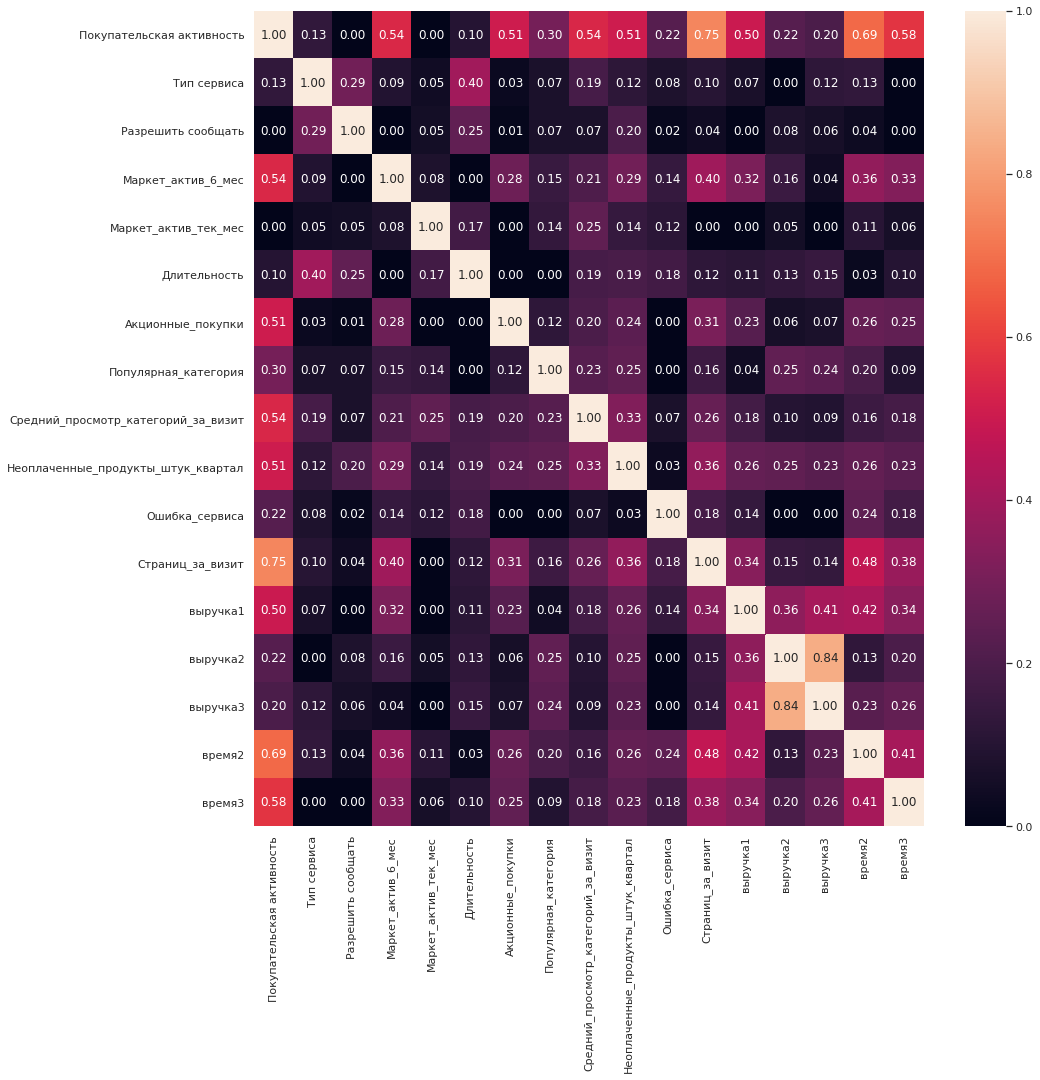

In [48]:
# визуализируем матрицу корреляции в виде тепловой карты
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(market.drop(['id'], axis=1).phik_matrix(), annot=True, fmt='.2f') 

Мультиколлениарности между признаками не обнаружено.

Далее посмотрим на корреляцию для каждого отдельного класс целевого признака.

In [49]:
# для класса "Снизилась"
market[market['Покупательская активность'] == 'Снизилась'].drop(['id'], axis=1).phik_matrix() 

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка1', 'выручка2', 'выручка3', 'время2', 'время3']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable Покупательская активность for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период1 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период2 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период3 for analysis 1. Dropping this column
  warnings.warn(


,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка1,выручка2,выручка3,время2,время3
Тип сервиса,1.000000,0.270449,0.129115,0.000000,0.400477,0.056124,0.104317,0.226420,0.160224,0.150046,0.170363,0.221292,0.000000,0.030954,0.178948,0.000000
Разрешить сообщать,0.270449,1.000000,0.000000,0.032900,0.238934,0.000000,0.215637,0.000000,0.177690,0.000000,0.070531,0.079843,0.167949,0.000000,0.000000,0.000000
Маркет_актив_6_мес,0.129115,0.000000,1.000000,0.223856,0.269087,0.220180,0.183761,0.212394,0.198051,0.086239,0.435827,0.359179,0.150997,0.184549,0.370440,0.304060
Маркет_актив_тек_мес,0.000000,0.032900,0.223856,1.000000,0.139678,0.000000,0.187794,0.357604,0.186687,0.166855,0.175500,0.000000,0.000000,0.094066,0.234435,0.182274
Длительность,0.400477,0.238934,0.269087,0.139678,1.000000,0.000000,0.000000,0.323279,0.270956,0.165554,0.199113,0.225174,0.225483,0.181397,0.000000,0.000000
Акционные_покупки,0.056124,0.000000,0.220180,0.000000,0.000000,1.000000,0.163983,0.130824,0.151004,0.000000,0.317488,0.188927,0.000000,0.102631,0.324229,0.303303
Популярная_категория,0.104317,0.215637,0.183761,0.187794,0.000000,0.163983,1.000000,0.062967,0.294511,0.056143,0.104784,0.000000,0.276140,0.255976,0.259658,0.120672
Средний_просмотр_категорий_за_визит,0.226420,0.000000,0.212394,0.357604,0.323279,0.130824,0.062967,1.000000,0.301348,0.112164,0.254174,0.235071,0.000000,0.000000,0.170606,0.123741
Неоплаченные_продукты_штук_квартал,0.160224,0.177690,0.198051,0.186687,0.270956,0.151004,0.294511,0.301348,1.000000,0.063936,0.267396,0.000000,0.245787,0.204223,0.299879,0.222317
Ошибка_сервиса,0.150046,0.000000,0.086239,0.166855,0.165554,0.000000,0.056143,0.112164,0.063936,1.000000,0.143420,0.139048,0.093930,0.038763,0.120347,0.130706


interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка1', 'выручка2', 'выручка3', 'время2', 'время3']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable Покупательская активность for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период1 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период2 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период3 for analysis 1. Dropping this column
  warnings.warn(


<AxesSubplot:>

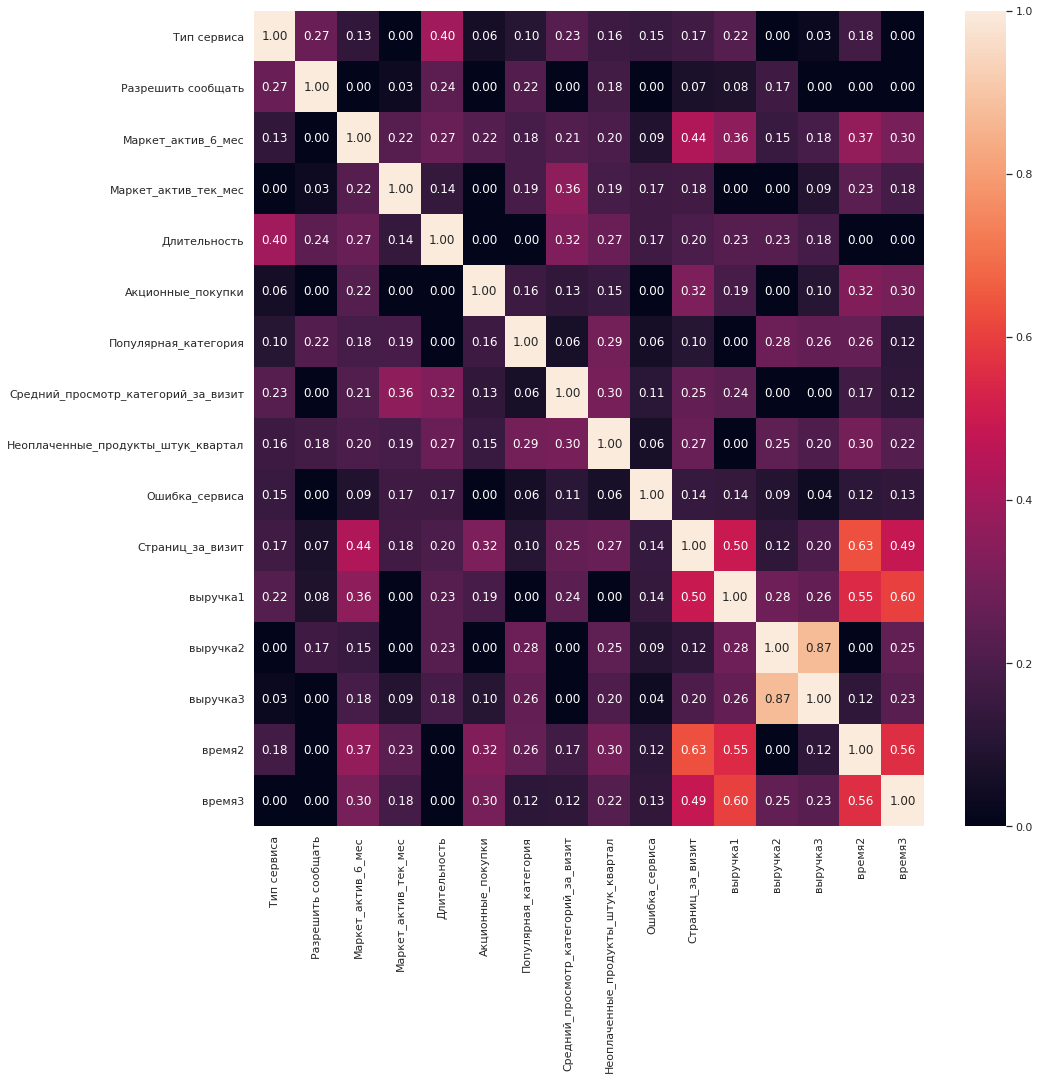

In [50]:
# визуализируем матрицу корреляции в виде тепловой карты для класса "Снизилась"
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(market[market['Покупательская активность'] == 'Снизилась'].drop(['id'], axis=1).phik_matrix(), annot=True, fmt='.2f') 

In [51]:
# для класса "Прежний уровень"
market[market['Покупательская активность'] == 'Прежний уровень'].drop(['id'], axis=1).phik_matrix() 

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка1', 'выручка2', 'выручка3', 'время2', 'время3']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable Покупательская активность for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период1 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период2 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период3 for analysis 1. Dropping this column
  warnings.warn(


,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка1,выручка2,выручка3,время2,время3
Тип сервиса,1.000000,0.293044,0.000000,0.056050,0.395860,0.000000,0.000000,0.133683,0.069945,0.000000,0.103943,0.000000,0.158301,0.115690,0.000000,0.172217
Разрешить сообщать,0.293044,1.000000,0.038701,0.067547,0.234514,0.063418,0.000000,0.115093,0.170493,0.024660,0.000000,0.030468,0.000000,0.000000,0.000000,0.000000
Маркет_актив_6_мес,0.000000,0.038701,1.000000,0.159854,0.000000,0.101504,0.126105,0.000000,0.000000,0.138019,0.000000,0.192076,0.351770,0.040376,0.000000,0.081394
Маркет_актив_тек_мес,0.056050,0.067547,0.159854,1.000000,0.157241,0.056968,0.254070,0.205234,0.147220,0.146153,0.000000,0.000000,0.000000,0.000000,0.000000,0.073355
Длительность,0.395860,0.234514,0.000000,0.157241,1.000000,0.000000,0.018976,0.028660,0.025546,0.224556,0.000000,0.002658,0.000000,0.227522,0.000000,0.187399
Акционные_покупки,0.000000,0.063418,0.101504,0.056968,0.000000,1.000000,0.000000,0.000000,0.032153,0.030268,0.000000,0.000000,0.000000,0.073573,0.000000,0.000000
Популярная_категория,0.000000,0.000000,0.126105,0.254070,0.018976,0.000000,1.000000,0.234219,0.239175,0.000000,0.155694,0.000000,0.230392,0.363295,0.146152,0.036022
Средний_просмотр_категорий_за_визит,0.133683,0.115093,0.000000,0.205234,0.028660,0.000000,0.234219,1.000000,0.207764,0.081617,0.055496,0.152694,0.000000,0.050208,0.122645,0.019083
Неоплаченные_продукты_штук_квартал,0.069945,0.170493,0.000000,0.147220,0.025546,0.032153,0.239175,0.207764,1.000000,0.000000,0.047480,0.121639,0.000000,0.000000,0.000000,0.068098
Ошибка_сервиса,0.000000,0.024660,0.138019,0.146153,0.224556,0.030268,0.000000,0.081617,0.000000,1.000000,0.000000,0.126096,0.000000,0.155586,0.181558,0.168871


interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка1', 'выручка2', 'выручка3', 'время2', 'время3']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable Покупательская активность for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период1 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период2 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable период3 for analysis 1. Dropping this column
  warnings.warn(


<AxesSubplot:>

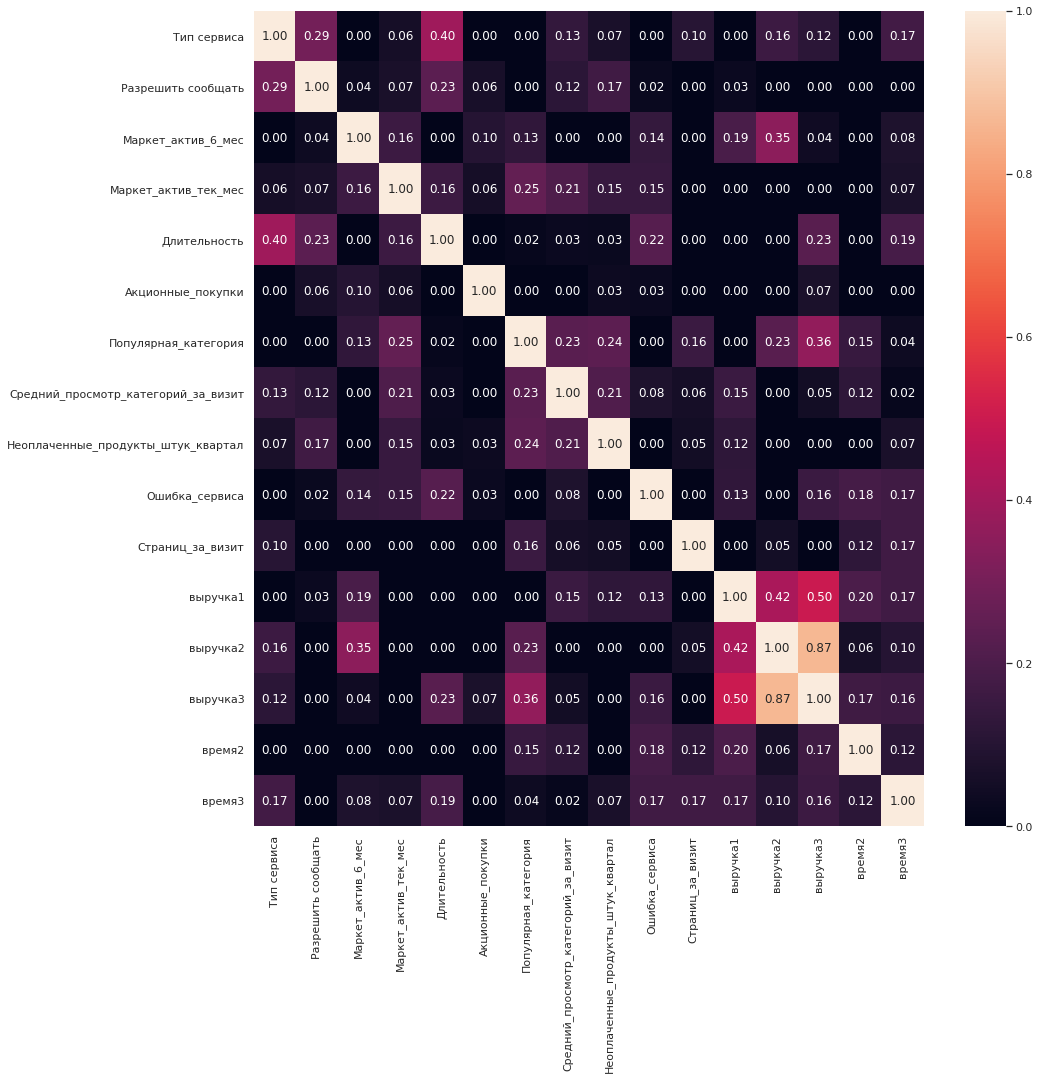

In [52]:
# визуализируем матрицу корреляции в виде тепловой карты для класса "Прежний уровень"
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(market[market['Покупательская активность'] == 'Прежний уровень'].drop(['id'], axis=1).phik_matrix(), annot=True, fmt='.2f') 

Мультиколлинеарности также не обнаружено, т.к. не связи с коэффициентов более 0.9. 
(0.9 есть, но не более этого значения)

#### Вывод 
- Мультиколлинеарности между входными признаками не обнаружно

### Пайплайн

In [53]:
# создадим пайплайн для подготовки данных и поиска лучшей модели
# зададим константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [54]:
# разделим данные на выборки
X = market.drop(['Покупательская активность', 'id', 'период1', 'период2', 'период3'], axis=1)
y = market['Покупательская активность']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE, 
    stratify = y)

print(X_train.shape) 
print(X_test.shape)

(972, 16)
(324, 16)


In [55]:
# создаём списки с названиями качественных и количественных признаков
ohe_col = ['Тип сервиса', 'Популярная_категория', 'Разрешить сообщать']
num_col = [
    'Маркет_актив_6_мес',
    'Маркет_актив_тек_мес',
    'Длительность', 
    'Акционные_покупки', 
    'Средний_просмотр_категорий_за_визит', 
    'Неоплаченные_продукты_штук_квартал', 
    'Ошибка_сервиса', 
    'Страниц_за_визит', 
    'выручка1', 
    'выручка2', 
    'выручка3', 
    'время2', 
    'время3']

In [56]:
# создаём пайплайн для подготовки признаков из списка ohe_col
ohe_pipe = Pipeline(
    [('SimpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', sparse_output=False,  handle_unknown='ignore'))
    ]
    )

In [57]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_col),
     ('num', MinMaxScaler(), num_col)
    ], 
    remainder='passthrough'
)


In [58]:
# создаём пайплайн 
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [59]:
# создаем словарь с моделями для возможности их перебора
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),  
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'poly' 
        )],
        'models__degree': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]


In [60]:
# закодируем целевой признак
label_encoder = LabelEncoder()
 
y_train_encod = label_encoder.fit_transform(y_train)

y_test_encod = label_encoder.transform(y_test)

In [61]:
# посмотрим какому классу какое значение было присвоено
pd.DataFrame(y_train_encod, y_train, columns=['LabelEncoder']).head(10)

,LabelEncoder
Покупательская активность,
Прежний уровень,0
Снизилась,1
Прежний уровень,0
Прежний уровень,0
Снизилась,1
Прежний уровень,0
Снизилась,1
Прежний уровень,0
Прежний уровень,0


In [62]:
# запустим поиск гиперпараметров

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train_encod)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Тип сервиса',
                                                   'Популярная_категория',
                                                   'Разрешить сообщать']),
                        

In [63]:
# теперь посчитаем метрику на тестовых данных

y_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика roc_auc_score на тестовой выборке: {roc_auc_score(y_test_encod, y_pred)}')

Метрика roc_auc_score на тестовой выборке: 0.9163936415483558


#### Вывод
- Был создан пайплайн для поиска подготовки данных и поиска наилучшей модели
- Для кодирования использовался OneHotEncoder, для масштабирование - MinMaxScaler
- Перебиралось 4 модели: SVC, DecisionTreeClassifier, LogisticRegression и KNeighborsClassifier с варьируемыми гиперпараметрами
- Поиск лучше модели производился при помощи случайного поиска
- Лучшая модель: LogisticRegression(C=3, penalty='l1', random_state=42, solver='liblinear')
- В качестве метрики была выбрана roc_auc_score, так как она стабильна при дисбалансе классов (у нас он минимальный, но все же), также нам не нужно было делать упор на конкретый класс
- Метрика на тренировочной выборке - 0.895, на тестовой - 0.916.

### Анализ важности признаков

In [64]:
# подготовим данные
ohe_pipe = randomized_search.best_estimator_['preprocessor'].transformers[0][1] 
num_pipe = randomized_search.best_estimator_['preprocessor'].transformers[1][1]

df_ohe = pd.DataFrame(ohe_pipe.fit_transform(X_test[ohe_col]), columns = ohe_pipe[1].get_feature_names_out()) 
df_num = pd.DataFrame(num_pipe.fit_transform(X_test[num_col]), columns = num_col)

X_test_final = pd.concat([df_ohe, df_num], axis=1)

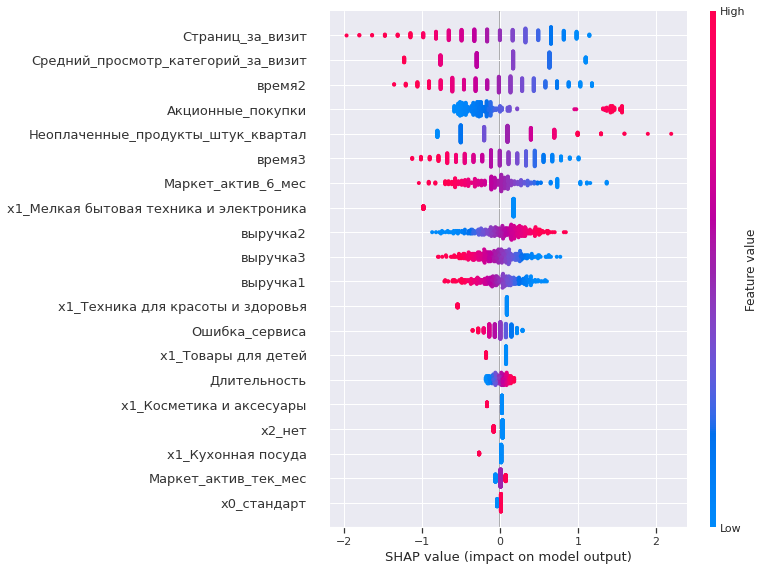

In [65]:
# для оценки важности признаков лучшей модели воспользуемся методом SHAP

explainer = shap.LinearExplainer(randomized_search.best_estimator_['models'], X_test_final)
shap_values = explainer(X_test_final)

shap.plots.beeswarm(shap_values, max_display=20)

#### Вывод
- Самые малозначимые признаки: маркетинговая активность за текущий месяц, разрешение на уведомления, категории товара, ошибка сервиса и тип сервиса
- Самые важные признаки (от которых наиболее зависит покупательская активность клиента): просмотр категорий за визит, количество просмотренных товаров за визит
- При принятии бизнес-решеий необходимо ориентироваться на эти данные, так как можно влиять на покупательскую активность, учитывая важные признаки

### Сегментация покупателей

In [66]:
# в качестве исследуемой группы выберу покупателей, которые имеют большую долю акционных покупок
# и их покупательская способность снижается с большой вероятностью
model = randomized_search.best_estimator_

results = pd.DataFrame(pd.concat([pd.Series(model.predict_proba(X_test)[:, 1]), 
                                  pd.Series(X_test.index)], axis=1))

results.columns = ['вероятность_cнижения', 'id']

results.head(10)

,вероятность_cнижения,id
0,0.013152,812
1,0.989131,305
2,0.102038,958
3,0.822703,152
4,0.503350,585
5,0.037392,1227
6,0.023098,1116
7,0.017788,1178
8,0.239425,536
9,0.193041,870


In [67]:
segment = market.merge(results, left_index=True, right_index=True)

In [68]:
segment = segment.query('вероятность_cнижения > 0.5 and Акционные_покупки > 0.5')

In [69]:
# проверим
segment = segment.merge(money, left_index=True, right_index=True).drop(['id_x', 'id_y'], axis=1)

segment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 1 to 321
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            33 non-null     object 
 1   Тип сервиса                          33 non-null     object 
 2   Разрешить сообщать                   33 non-null     object 
 3   Маркет_актив_6_мес                   33 non-null     float64
 4   Маркет_актив_тек_мес                 33 non-null     int64  
 5   Длительность                         33 non-null     int64  
 6   Акционные_покупки                    33 non-null     float64
 7   Популярная_категория                 33 non-null     object 
 8   Средний_просмотр_категорий_за_визит  33 non-null     int64  
 9   Неоплаченные_продукты_штук_квартал   33 non-null     int64  
 10  Ошибка_сервиса                       33 non-null     int64  
 11  Страниц_за_визит                 

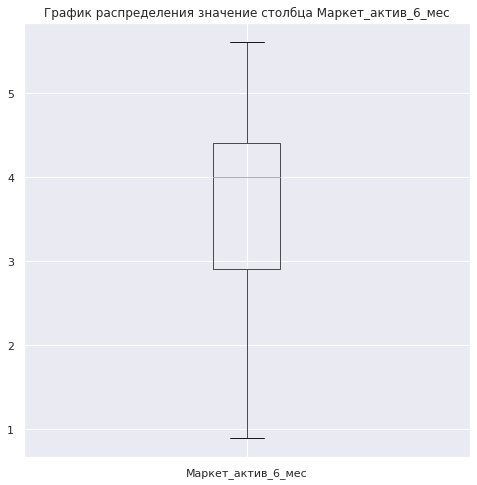

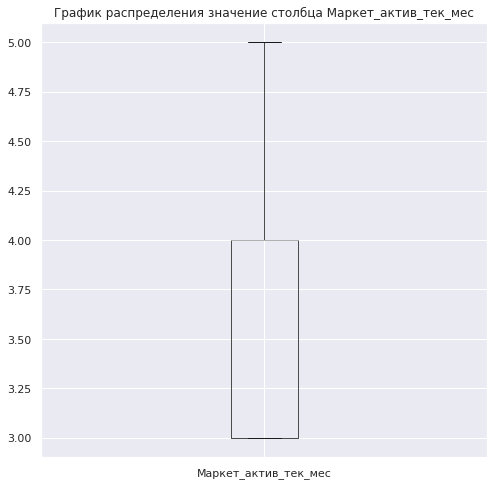

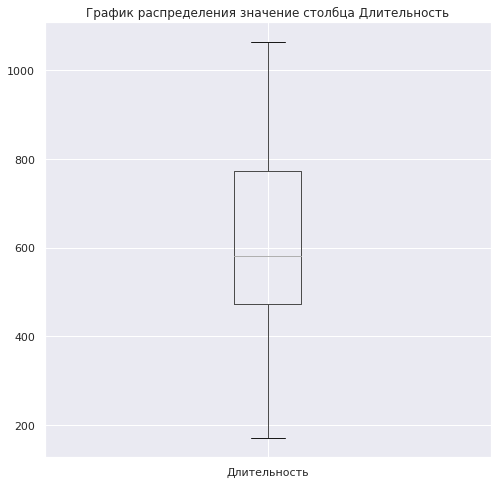

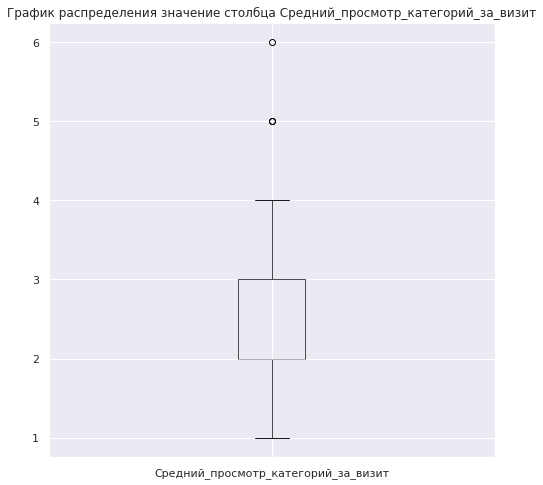

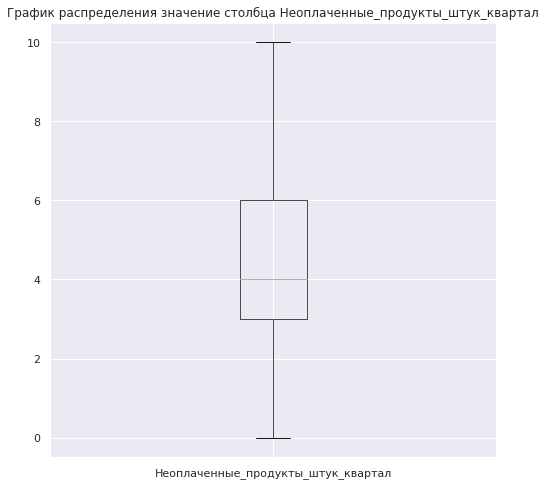

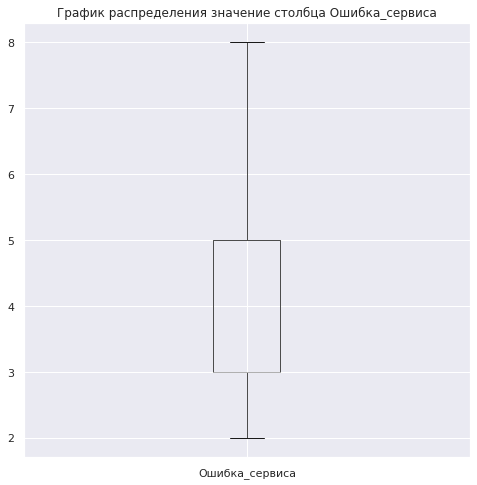

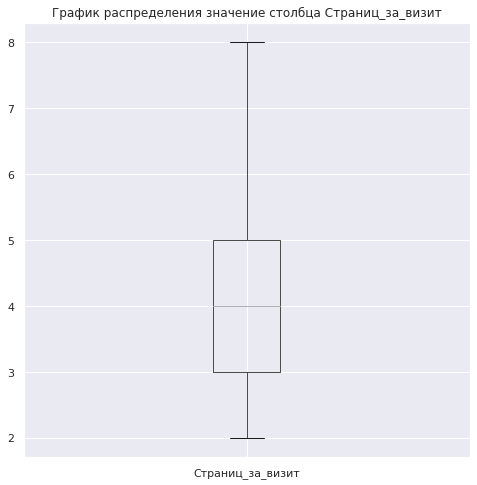

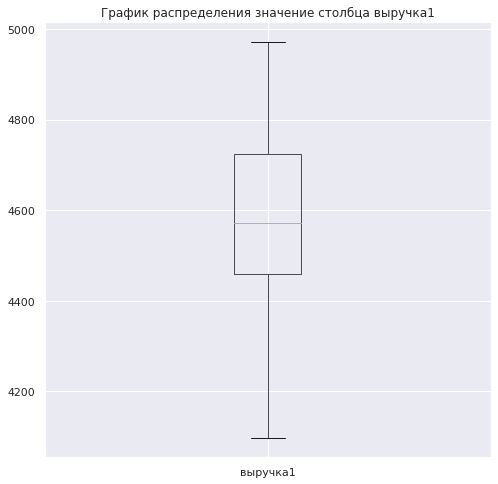

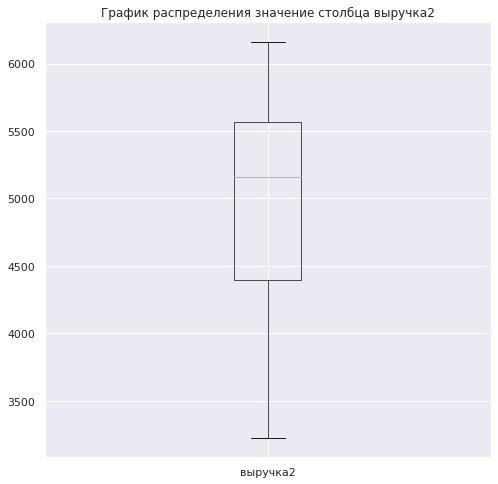

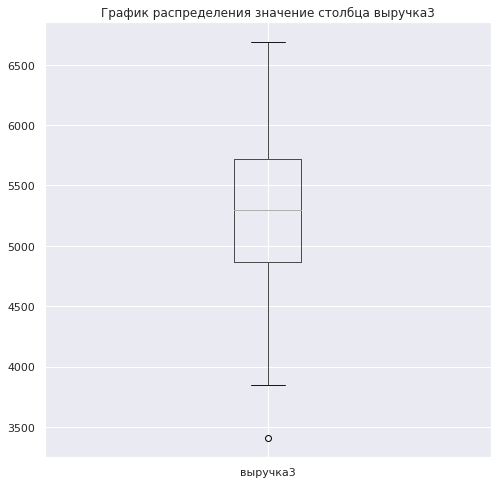

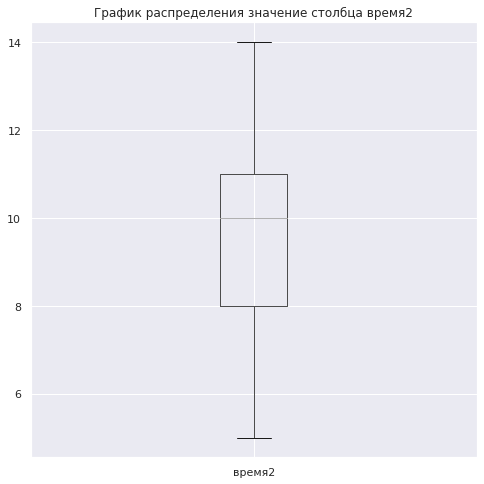

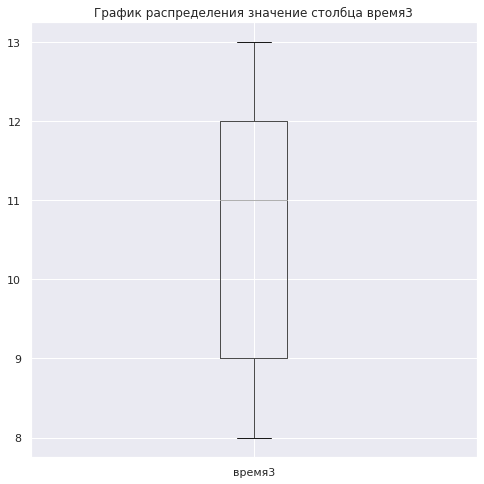

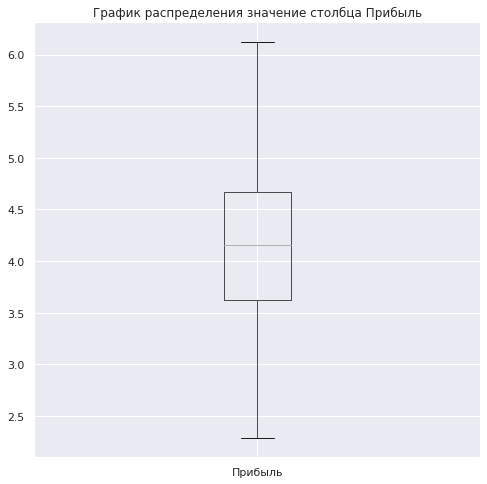

In [70]:
# построим графики для количесвтенных и категориальных данных для анализ
# строим ящик с усами
graph_box(segment[['Маркет_актив_6_мес',
                   'Маркет_актив_тек_мес',
                   'Длительность', 
                   'Средний_просмотр_категорий_за_визит', 
                   'Неоплаченные_продукты_штук_квартал', 
                   'Ошибка_сервиса', 
                   'Страниц_за_визит', 
                   'выручка1', 
                   'выручка2', 
                   'выручка3', 
                   'время2', 
                   'время3', 
                   'Прибыль']])

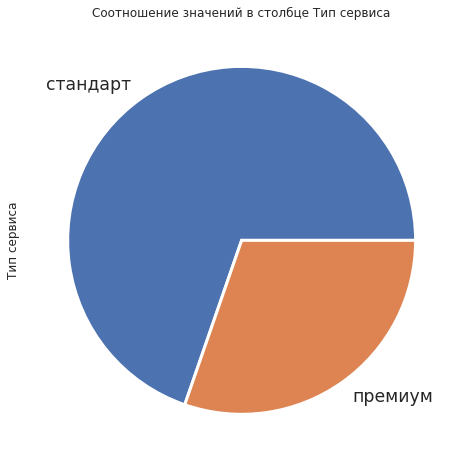

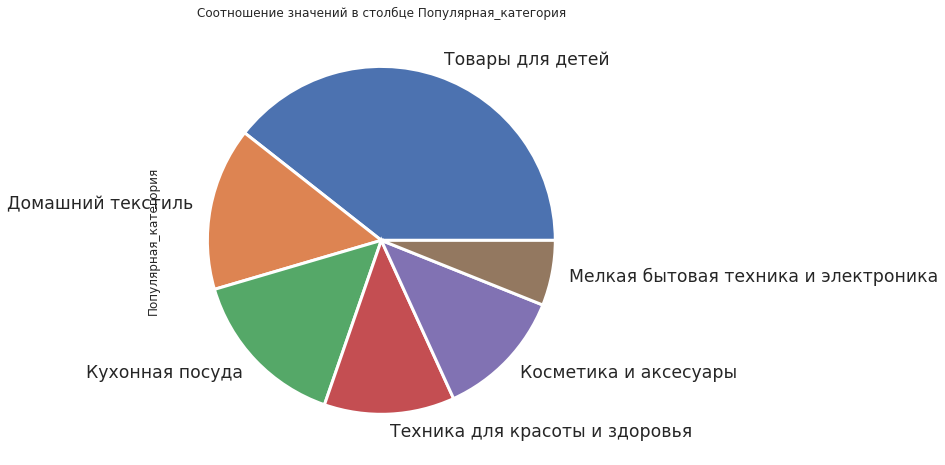

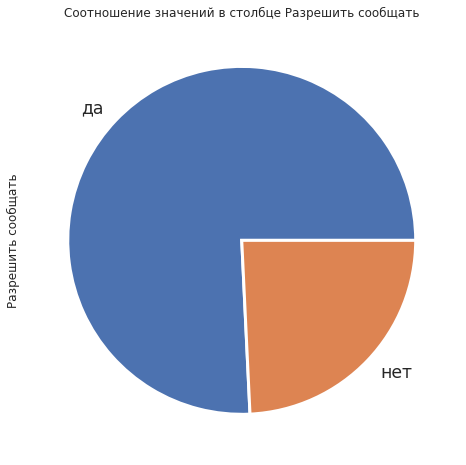

In [71]:
# строим круговые диаграммы
graph_pie(segment[['Тип сервиса', 'Популярная_категория', 'Разрешить сообщать']])

#### Вывод
- Был выделен сегмент покупателей с большой долей акционных покупов и большой вероятностью снижения покупательской активности
- Каждый покупатель данного сегмента приносит в среднем около 5000 выручки каждый месяц
- К тому же, большая часть покупателей данного сегмента чаще всего покупают либо детские товары, либо косметику
- Скорее всего, большая часть покупателей - это молодые мамы
- Многие клиенты согласны на отправку уведомлений, а также большинство имеет стандартый тип сервиса

***Предложения:***
- Сделать больше скидок в категориях "Товары для детей" и "Косметика и аксессуары"
- Уведомления о скидках или промокоды можно рассылать на мобильный телефон или на почту
- Можно предложить бесплатную подписку на премиальный сервис на небольшой срок, где будет доступна бесплатная доставка, а также будут дополнительные акции
- Также на товары, которые долгое время лежат в корзине без оплаты, можно делать небольшую скидку
- К тому же, большинство покупателей уже постоянные клиенты, думаю в связи с этим также можно дать какой-то промокод на подобие: "Вы с нами уже давно, и за это мы хотим Вас отблагодарить промокодом..."
- Также нужно поработать с рекомендациями и предлагать клиентам больше интересующий товаров, ведь от просмотра категорий и товаров покупательская активность зависит больше всего

### Выводы

#### Загрузка данных
- Произвелась выгрузка данных
- Данные в таблицах соответствуют описанию
- Все данные представлены необходимым типом

#### Предобработка данных
- Была проведена предобработка данных
- Ошибки в данных были исправлены
- Пропуски и дубликаты обнаружены не были

#### Исследовательский анализ
- Был проведен исследовательский анализ данных
- Была изучена матрица описания данных, а также построены графики для различных типов данных
- Некоторые количественные признаки распределены ненормально (соответственно, при корреляционном анализе корреляция Пирсона не подходит)
- Было аномальное значение, которое было удалено
- У целевого признака наблюдается небольшой дисбаланс (примерно 40 к 60), но это не критично, используем стратификацию при разделении на выборки

#### Объединение таблиц
- Произовдилось объединение трёх таблиц в один датафрейм
- В новой таблице каждому периоду соответствует отдельный столбец

#### Корреляционный анализ
- Мультиколлинеарности между входными признаками не обнаружено

#### Пайплайн
- Был создан пайплайн для поиска подготовки данных и поиска наилучшей модели
- Для кодирования использовался OneHotEncoder, для масштабирование - MinMaxScaler
- Перебиралось 4 модели: SVC, DecisionTreeClassifier, LogisticRegression и KNeighborsClassifier с варьируемыми гиперпараметрами
- Поиск лучше модели производился при помощи случайного поиска
- Лучшая модель: LogisticRegression(C=3, penalty='l1', random_state=42, solver='liblinear')
- В качестве метрики была выбрана roc_auc_score, так как она стабильна при дисбалансе классов (у нас он минимальный, но все же), также нам не нужно было делать упор на конкретый класс
- Метрика на тренировочной выборке - 0.9, на тестовой - 0.87.

#### Анализ важности признаков
- Самые малозначимые признаки: маркетинговая активность за текущий месяц, разрешение на уведомления, категории товара, ошибка сервиса и тип сервиса
- Самые важные признаки (от которых наиболее зависит покупательская активность клиента): просмотр категорий за визит, количество просмотренных товаров за визит
- При принятии бизнес-решеий необходимо ориентироваться на эти данные, так как можно влиять на покупательскую активность, учитывая важные признаки

#### Вывод
- Был выделен сегмент покупателей с большой долей акционных покупов и большой вероятностью снижения покупательской активности
- Каждый покупатель данного сегмента приносит в среднем около 5000 выручки каждый месяц
- К тому же, большая часть покупателей данного сегмента чаще всего покупают либо детские товары, либо косметику
- Скорее всего, большая часть покупателей - это молодые мамы
- Многие клиенты согласны на отправку уведомлений, а также большинство имеет стандартый тип сервиса

***Предложения:***
- Сделать больше скидок в категориях "Товары для детей" и "Косметика и аксессуары"
- Уведомления о скидках или промокоды можно рассылать на мобильный телефон или на почту
- Можно предложить бесплатную подписку на премиальный сервис на небольшой срок, где будет доступна бесплатная доставка, а также будут дополнительные акции
- Также на товары, которые долгое время лежат в корзине без оплаты, можно делать небольшую скидку
- К тому же, большинство покупателей уже постоянные клиенты, думаю в связи с этим также можно дать какой-то промокод на подобие: "Вы с нами уже давно, и за это мы хотим Вас отблагодарить промокодом..."
- Также нужно поработать с рекомендациями и предлагать клиентам больше интересующий товаров, ведь от просмотра категорий и товаров покупательская активность зависит больше всего

# Заключение
- По итогам работы была обучена модель МО для предсказывания покупательской способности в ближайшие месяцы
- Лучше всего справилась логистическая регрессия
- Метрика на тренировочной выборке - 0.9, а на тестовой - 0.87
- Наиболее покупательская способность зависит от количества просмотренных страниц и количества просмотренных категорий
- Для сохранения покупательской способности у клиентов, которые покупают много товаров по акции, следует делать упор на категории "Товары для детей" и "Косметика и аксессуары", а также сделать упор как раз на высокозначимые переменные (можно поработать над рекомендациями)